<img src="img/decisionmaking.png" width="400px">

<p style="font-size:35px">ELEC-E7890 - User Research</p>
<p style="font-size:30px">Lecture 8 - Developing Brain-Computer Interfaces</p>

**Carlos de la Torre Ortiz**

University of Helsinki

<div class="alert alert-block alert-success">
<h2><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Learning objectives</h2>
<ul>
<li>Adquiring the flexibility to work with domain-specific tools.</li>
<li>Handling and processing real user data.</li>
<li>Drafting interactive methods accounting for data limitations.</li>
</ul>
</div>

#### Python setup <a class="tocSkip"></a>

In [188]:
# Import the libraries.
import os
import sys
import numpy as np
import autoreject
from autoreject.utils import interpolate_bads
import matplotlib.pyplot as plt
import mne
from mne.datasets import spm_face
from mne.preprocessing import ICA, create_eog_epochs
from mne import io, combine_evoked
from mne.minimum_norm import make_inverse_operator, apply_inverse
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# import seaborn as sns
# sns.set_theme(context="notebook", style="white")

%config InlineBackend.figure_format="retina"

sep = lambda: print("-" * 30)

# Bad channels? 

In [5]:
epochs = mne.read_epochs("data_lec8/epochs_clean.fif")

Reading data_lec8/epochs_clean.fif ...
    Found the data of interest:
        t =     -99.61 ...     400.39 ms
        0 CTF compensation matrices available
Adding metadata with 13 columns
Replacing existing metadata with 13 columns
222 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-5-d3148619ee25>:1: RuntimeWarning: This filename (data_lec8/epochs_clean.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs("data_lec8/epochs_clean.fif")


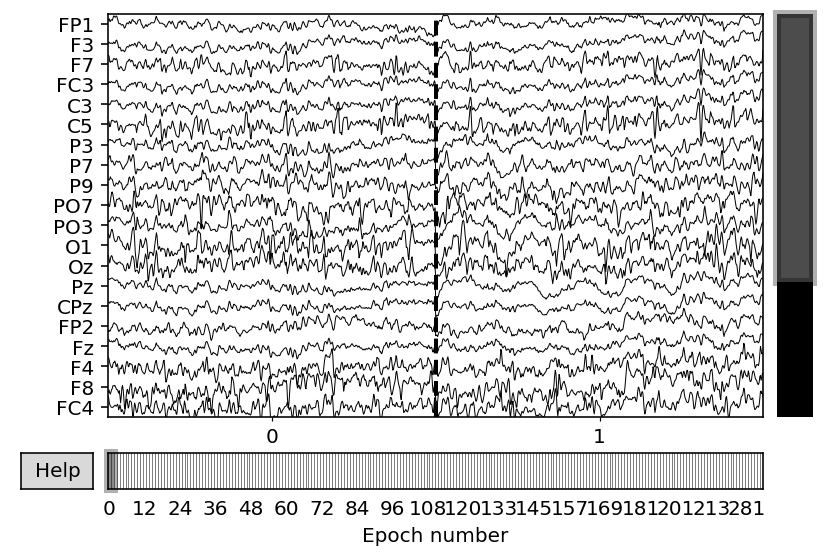

In [27]:
epochs.plot(n_epochs=2, n_channels=20);

**Note: you may see this better if you execute the code using a Python script instead of a notebook.**

# New classification algorithm?

## Load the data and preprocess it

In [192]:
# Might need these two lines to bypass the certificates verifications
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Set the paths and download the data if not present
data_path = spm_face.data_path() 
raw_path = os.path.join(
    data_path, "MEG", "spm", "SPM_CTF_MEG_example_faces%d_3D.ds")

# WARNING: slow!
# Read the data, taking only the first run
raw = io.read_raw_ctf(raw_path % 1, preload=True)

# Do quit filtering
raw.filter(1, 30, method='fir', fir_design='firwin')

# Get events
events = mne.find_events(raw, stim_channel='UPPT001')
event_ids = {"faces": 1, "scrambled": 2}

# Getting the epochs 
picks = mne.pick_types(raw.info, meg=True, exclude='bads')
tmin, tmax = -0.2, 0.6
baseline = None  # no baseline as high-pass is applied
reject = dict(mag=5e-12)
epochs = mne.Epochs(raw, events, event_ids, tmin, tmax, picks=picks,
                    baseline=baseline, preload=True, reject=reject)

ds directory : /Users/niochea1/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.90   72.01    0.00 mm <->   -0.90   72.01    0.00 mm (orig :  -43.09   61.46 -252.17 mm) diff =    0.000 mm
       0.90  -72.01    0.00 mm <->    0.90  -72.01    0.00 mm (orig :   53.49  -45.24 -258.02 mm) diff =    0.000 mm
      98.30    0.00    0.00 mm <->   98.30   -0.00    0.00 mm (orig :   78.60   72.16 -241.87 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /Users/niochea1/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds/SPM_CTF_MEG_example_faces1_3D.meg4: 
    System clock channel is available, checking which samples are valid.
    1 x 324474 = 324474 samples from 34

In [49]:
def find_dividend_for_remainder(dividend, divisor, target_remainder=0):
    """Operation"""
    term = 0
    remainder = 1 
    while remainder != target_remainder:
        remainder = (dividend - term) % divisor
        term += 1

    return dividend - term + 1

def vectorize_epoch_data(epoch_data, frames):
    """Transform epoch data into tensor of shape: event x time_frame*channels."""

    time_axis = 2  # axes: event x channel x time

    data = epoch_data.get_data()

    # Get how many points to preserve to form equal split time frames
    mod_time = find_dividend_for_remainder(
        dividend=data.shape[time_axis], divisor=frames
    )

    # Split data into frames of the same size, discarding points that would prevent that
    split = np.split(data[:, :, :mod_time], frames, axis=time_axis)

    # Average time points within each frame and concat all now averaged frames
    mean = np.hstack([np.mean(split_part, axis=2) for split_part in split])

    return mean

faces = vectorize_epoch_data(epochs["faces"], 7)
scrambled = vectorize_epoch_data(epochs["scrambled"], 7)

In [154]:
# Put the data in right shape for training the algorithm
X = np.vstack((faces, scrambled))
X = StandardScaler().fit_transform(X) # Scale the data
y_rel = np.ones(len(faces), dtype=int)
y_irrel = np.zeros(len(scrambled), dtype=int)
y = np.hstack((y_rel, y_irrel))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0)

## Example using LDA

In [194]:
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
lda_model = lda.fit(X_train, y_train)
lda_y_pred = lda_model.predict(X_test)

In [195]:
accuracy_score(y_test, lda_y_pred)

0.9285714285714286

## Example using logistic regression

In [198]:
log = LogisticRegression()
log_model = log.fit(X_train, y_train)
log_y_pred = log_model.predict(X_test)

In [199]:
accuracy_score(y_test, log_y_pred)

0.875